In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score, auc

In [73]:
df = pd.read_csv('C:/Users/cheryl/Downloads/df_for_model.csv', encoding='latin-1')

In [74]:
df1 = df

In [5]:
embedded_cols = ["Job Title_embed","Profile_embed","Department_embed","Job_Description_embed","Requirements_embed",
                "Job_Benefits_embed","Type_of_Industry_embed","Operations_embed","City_embed"]
categorical_feats = ["Qualification_bachelor's degree", "Salary_Specified", "Type_of_Employment_unspecified",
                     "Qualification_high school", "City_Specified", "Experience_entry level","Qualification_master's degree",
                     "Experience_unspecified", "Telecomunication","Qualification_vocational / certification/ professional",
                     "Experience_midsenior level", "Qualification_unspecified", "Type_of_Employment_fulltime"]

In [6]:
def convert_to_array(s):
    # Clean the string
    cleaned_str = s.strip('[]').replace('\n', ' ').replace('  ', ' ').strip()
    # Convert the cleaned string to a NumPy array
    return np.fromstring(cleaned_str, sep=' ')

for col in embedded_cols:
    df1[col] = df1[col].apply(convert_to_array)

In [7]:
scaler = StandardScaler()
X_text = np.hstack([np.vstack(df1[col]) for col in embedded_cols])
X_cat = df1[categorical_feats].values
X_num = df1[['Range_of_Salary']]
X = np.hstack([X_text, X_cat, X_num])

X_std = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

# Plot Explained Variance Ratio
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

In [ ]:
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.show()

In [39]:
pca = PCA(n_components= 50)
X_pca = pca.fit_transform(X_std)
explained_variance = pca.explained_variance_ratio_
variance_first_1000 = explained_variance.sum()
print(f"Variance explained by first 1000 components: {variance_first_1000:.3f}")

Variance explained by first 1000 components: 0.511


In [40]:
df2 = pd.DataFrame(X_pca)

In [57]:
y = df1['Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size = 0.2, random_state = 4263)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8524, 50)
(2132, 50)
(8524,)
(2132,)


In [ ]:
print("Counts of label '1' in training data: {}".format(sum(y_train == 1)))
print("Counts of label '0' in training data: {}".format(sum(y_train == 0)))

In [56]:
def resampling_method(method,X_train,y_train):
    if method == 'Undersampling':
        rus = RandomUnderSampler(random_state=4263)
        X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
    elif method == 'Oversampling':
        ros = RandomOverSampler(random_state=4263)
        X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
    else:
        print('Invalid resampling method')
    resampled_class_counts = pd.Series(y_train_balanced).value_counts()
    print("Resampled class counts:")
    print(resampled_class_counts)
    return X_train_balanced, y_train_balanced
        

In [60]:
model = LogisticRegression(max_iter = 500, random_state = 4263, penalty='l1', solver='saga')
X_train_balanced, y_train_balanced = resampling_method('Oversampling',X_train,y_train)
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test)

Resampled class counts:
0    7936
1    7936
Name: Fraudulent, dtype: int64


In [61]:
def evaluate_model(y_test,y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix for {model_name}')
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return cm

Accuracy: 0.9596622889305816
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1990
           1       0.68      0.73      0.71       142

    accuracy                           0.96      2132
   macro avg       0.83      0.85      0.84      2132
weighted avg       0.96      0.96      0.96      2132



array([[1942,   48],
       [  38,  104]], dtype=int64)

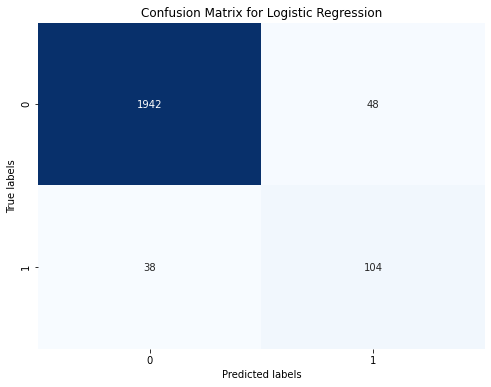

In [33]:
evaluate_model(y_test,y_pred,'Logistic Regression')

In [77]:
def auc_roc(model,model_name,X_test,y_test):
    pred_prob = model.predict_proba(X_test)
    auc_score = round(roc_auc_score(y_test, pred_prob[:,1]),3)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    plt.plot(fpr, tpr, linestyle='--',color='orange', label ='ROC curve (area = %0.3f)' % auc_score)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    
    return print(f'AUC score: {auc_score}')
    

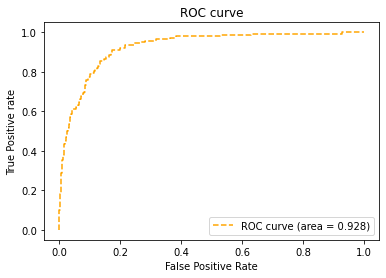

AUC score: 0.928


In [78]:
auc_roc(model,'Logistic Regression',X_test,y_test)

In [34]:
rfc = RandomForestClassifier(random_state = 4263, max_features='sqrt',n_estimators=100,max_depth = 10, n_jobs=-1)
rfc.fit(X_train_balanced, y_train_balanced)
y_pred = rfc.predict(X_test)

Accuracy: 0.9643527204502814
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1990
           1       0.97      0.48      0.64       142

    accuracy                           0.96      2132
   macro avg       0.97      0.74      0.81      2132
weighted avg       0.96      0.96      0.96      2132



array([[1988,    2],
       [  74,   68]], dtype=int64)

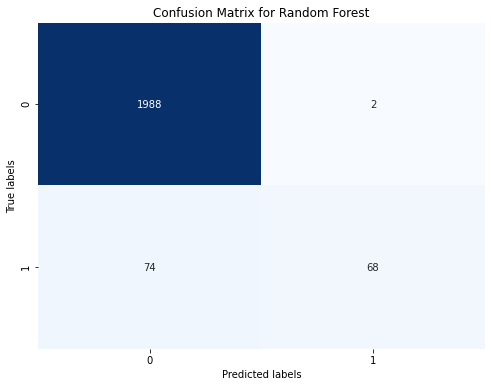

In [35]:
evaluate_model(y_test,y_pred,'Random Forest')

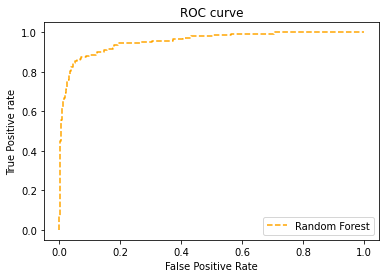

AUC score: 0.955


In [36]:
auc_roc(model,'Random Forest',X_test,y_test)